In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

许多机器学习问题涉及训练实例的几千甚至上百万个特征。将会看到，这不仅导致训练非常缓慢，也更加难以找到好的解决方案。这个问题通常被称为`维度的诅咒`。

幸运的是，对现实世界的问题，一般可以大量减少特征的数量，将棘手的问题转化成容易解决的问题。例如，MNIST图像：图像边框的像素位上几乎全是白色，所以完全可以在训练集中抛弃这些像素位，也不会丢失太多信息。图7-6也证实了这些像素对于分类任务来说完全无足轻重。此外，两个相邻像素通常是高度相关的：如果将它们合并成一个像素（例如，取两个像素强度的平均值），也不会丢失太多信息。

> 数据降维确实会丢失一些信息（就好比将图像压缩为JPEG会降低其质量一样），所以，它虽然能够加速训练，但是也会轻微降低系统性能。同时它也让流水线更为复杂，维护难度上升。所以，如果训练太慢，首先应该尝试的还是继续使用原始数据，然后再考虑数据降维。不过在某些情况下，降低训练数据的维度可能会滤除掉一些不必要的噪声和细节，从而导致性能更好（但通常来说不会，它只会加速训练）。

除了加快训练，降维对于数据可视化（或称DataViz）也是非常有用的。将维度降到两个（或三个），就可以在图形上绘制出高维训练集，通过视觉来检测模式，常常可以获得一些十分重要的洞察，比如说聚类。

本章将探讨维度的诅咒，大致了解高维空间中发生的事情。然后，介绍两种主要的数据降维方法（投影和流形学习），并学习现在最流行的三种数据降维技术：PCA、Kernal PCA以及LLE。

## 维度的诅咒

人们太习惯三维空间的生活 [1] ，所以当试图去想象一个高维空间时，直觉思维很难成功。即使是一个基本的四维超立方体（参见图8-1），也很难在脑海中想象出来，更不用说在一个千维空间中弯曲的200维椭圆体。

![图8-1：点、线、面、立方体和超立方体（从零维到四维超立方体）](images/VNote/20201124171325830_29998.png)

事实证明，在高维空间中，许多事物的行为都迥然不同。例如，如果在一个单位平面（$1\times1$的正方形）内随机选择一个点，那么这个点离边界的距离小于0.001的概率只有约0.4%（也就是说，一个随机的点不大可能刚好位于某个维度的“极端”）。但是，在一个10000维的单位超立方体（$1\times1\times\dots\times1$立方体，一万个1）中，这个概率大于99.999999%。高维超立方体中大多数点都非常接近边界。 [3]

还有一个更麻烦的区别：如果在单位平面中随机挑两个点，这两个点之间的平均距离大约为0.52。如果在三维的单位立方体中随机挑两个点，两点之间的平均距离大约为0.66。但是，如果在一个100万维的超立方体中随机挑两个点呢？不管相信与否，平均距离大约为408.25（约等于$\sqrt{1000000/6}$）！这是非常违背直觉的：位于同一个单位超立方体中的两个点，怎么可能距离如此之远？这个事实说明高维数据集有很大可能是非常稀疏的：大多数训练实例可能彼此之间相距很远。当然，这也意味着新的实例很可能远离任何一个训练实例，导致预测跟低维度相比，更加不可靠，因为它们基于更大的推测。简而言之，**训练集的维度越高，过度拟合的风险就越大**。

理论上来说，通过增大训练集，使训练实例达到足够的密度，是可以解开维度的诅咒的。然而不幸的是，实践中，要达到给定密度所需要的训练实例数量随着维度增加呈指数式上升。仅仅100个特征下（远小于MNIST问题），要让所有训练实例（假设在所有维度上平均分布）之间的平均距离小于0.1，需要的训练实例数量就比可观察宇宙中的原子数量还要多。

[1] 如果算上时间就是四维，或者如果你是个字符串理论家，还可以再高几个维度。

[2] 在http://goo.gl/OM7ktJ 上可以观看一个投影到三维空间的旋转超立方体。图片由维基百科用户NerdBoy1932提供（Creative Commons BY-SA 3.0（https://creativecommons.org/licenses/bysa/3.0/ ）），转载自https://en.wikipedia.org/wiki/Tesseract。

[3] 趣味事实：只要考虑足够多的维度，每个人，至少在某一个维度上，都可能算是个极端主义者（比如，他们在咖啡里放多少糖）。

## 数据降维的主要方法

在深入了解具体的降维算法之前，先来看看降维的两种主要方法：投影和流形学习。

### 投影

在大多数现实世界的问题里，训练实例在所有维度上并不是均匀分布的。许多特征几乎是不变的，也有许多特征是高度相关联的（如前面讨论的MNIST数据集）。因此，高维空间的所有训练实例实际上（或近似于）受一个低得多的低维子空间所影响。这听起来很抽象，所以我们来看一个例子。在图8-2中，你可以看到一个由圆圈表示的3D数据集。

In [2]:
np.random.seed(5)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [4]:
X3D_inv = pca.inverse_transform(X2D)

In [5]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

In [6]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

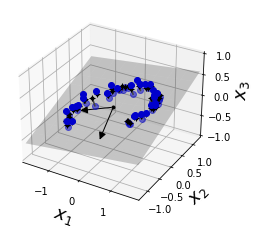

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

# save_fig("dataset_3d_plot")
plt.show()

注意看，所有的训练实例都紧挨着一个平面：这就是高维（3D）空间的低维（2D）子空间。现在，如果将每个训练实例垂直投影到这个子空间（如图中实例到平面之间的短线所示），将得到如图8-3所示的新2D数据集。已经将数据集维度从三维降到了二维。注意，图中的轴对应的是新特征$z_1$ 和$z_2$ （平面上投影的坐标）。

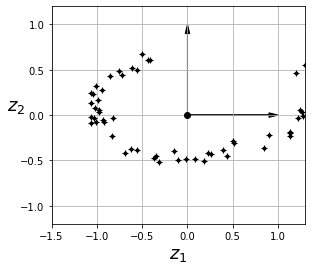

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
# save_fig("dataset_2d_plot")

图8-3：投影后产生的新2D数据集

不过投影并不总是降维的最佳方法。在许多情况下，子空间可能会弯曲或转动，比如图8-4所示的著名的瑞士卷玩具数据集。

In [9]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=55)

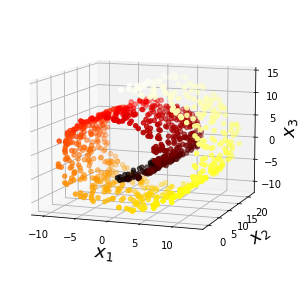

In [10]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("swiss_roll_plot")
plt.show()

图8-4：瑞士卷数据集

简单地进行平面投影（例如放弃$x_3$ ）会直接将瑞士卷的不同层压扁在一起，如图8-5的左图所示。但是真正想要的是将整个瑞士卷展开铺平以后的2D数据集，如图8-5的右图所示。

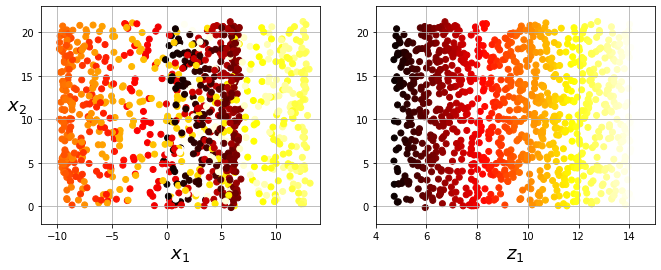

In [11]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

#save_fig("squished_swiss_roll_plot")
plt.show()

图8-5：投影到平面（左）和展开瑞士卷（右）

### 流形学习

瑞士卷就是二维流形的一个例子。简单地说，2D流形就是一个能够在更高维空间里面弯曲和扭转的2D形状。更概括地说，$d$维流形就是$n$（其中，$d＜n$）维空间的一部分，局部类似于一个$d$维超平面。在瑞士卷的例子中，$d=2$，$n=3$：它局部类似于一个2D平面，但是在第三个维度上卷起。

许多降维算法是通过对训练实例进行流形建模来实现的，这被称为`流形学习`。它依赖于流形假设，也称为流形假说，认为大多数现实世界的高维度数据集存在一个低维度的流形来重新表示。这个假设通常是**凭经验观察**的。

再次说到MNIST数据集：所有手写的数字图像都有一些相似之处。它们由相连的线条组成，边界都是白色的，或多或少是居中的，等等。如果随机生成图像，只有少到不能再少的一部分可能看起来像手写数字。也就是说，如果要创建一个数字图像，拥有的自由度要远远低于允许创建任意图像的自由度。而这些限制正倾向于将数据集挤压成更低维度的流形。

流形假设通常还伴随着一个隐含的假设：如果能用低维空间的流形表示，手头的任务（例如分类或者回归）将变得更简单。例如，图8-6的上面一行，瑞士卷被分为两类：3D空间中（左上）决策边界将会相当复杂，但是在展开的2D流形空间（右上），决策边界是一条简单的直线。

但是，这个假设并不总是成立。例如，图8-6的底行，决策边界在$x_1 =5$处，在原始的3D空间中，这个边界看起来非常简单（一个垂直的平面），但是在展开的流形中，决策边界看起来反而更为复杂（四个独立线段的集合）。

简而言之，在训练模型之前降低训练集的维度，肯定可以加快训练速度，但这并不总是会导致更好或更简单的解决方案，它取决于数据集。

希望现在对于维度的诅咒有了一个很好的理解，也知道降维算法是怎么对付它的，特别是当流形假设成立的时候，应该怎么处理。本章剩余部分将逐一介绍几个最流行的算法。

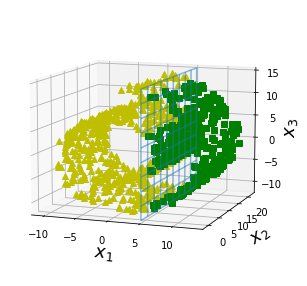

In [12]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("manifold_decision_boundary_plot1")
plt.show()

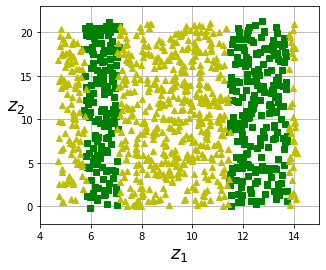

In [13]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# save_fig("manifold_decision_boundary_plot2")
plt.show()

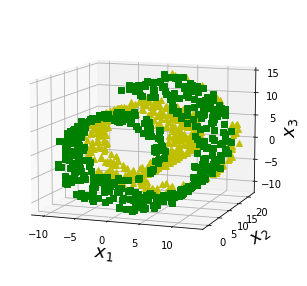

In [14]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# save_fig("manifold_decision_boundary_plot3")
plt.show()

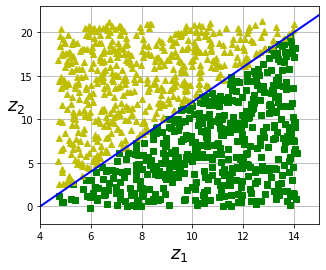

In [15]:
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#save_fig("manifold_decision_boundary_plot4")
plt.show()

图8-6：决策边界不总是维度越低越简单

## PCA

主成分分析（PCA）是迄今为止最流行的降维算法。它先是识别出最接近数据的超平面，然后将数据投影其上。

### 保留差异性

将训练集投影到低维超平面之前，需要选择正确的超平面。例如图8-7的左图代表一个简单的2D数据集，沿三条不同的轴（即一维超平面）。右图是将数据集映射到每条轴上的结果。正如你所见，在实线上的投影保留了最大的差异性，而点线上的投影只保留了非常小的差异性，虚线上的投影差异性居中。

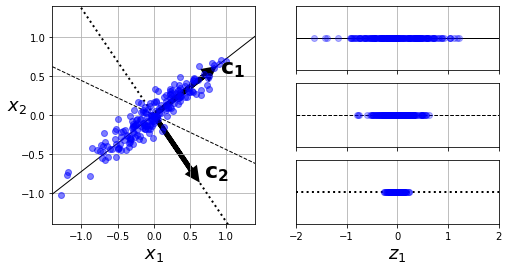

In [16]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(5)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

#save_fig("pca_best_projection")
plt.show()

图8-7：选择投影的子空间

选择保留最大差异性的轴看起来比较合理，因为它可能比其他两种投影丢失的信息更少。要证明这一选择，还有一种方法，比较原始数据集与其轴上的投影之间的均方距离，使这个**均方距离最小的轴是最合理的选择**，也就是实线代表的轴。这也正是PCA背后的简单思想（ http://goo.gl/gbNo1D ）。 [1]

### 主成分

主成分分析（PCA）可以在训练集中识别出哪条轴对差异性的贡献度最高。在图8-7中，即是由实线表示的轴。同时它也找出了第二条轴，它对剩余差异性的贡献度最高，与第一条轴垂直。因为这个例子是二维的，所以除了这条点线再没有其他。如果是在更高维数据集中，PCA还会找到与前两条都正交的第三条轴，以及第四条、第五条，等等——轴的数量与数据集维度数量相同。

定义第$i$条轴的单位向量就叫作第$i$个主成分（PC）。图8-7中，第一个主成分是$c_1$ ，第二个主成分是$c_2$ 。在图8-2中，前两个主成分是平面里正交的箭头所示，第三个主成分则是垂直于平面（向上或向下）。

> 主成分的方向是不稳定的：如果稍微打乱训练集，然后重新运行PCA，部分新的主成分可能指向跟原来的主成分相反的方向。但是，它们通常还是在同一条轴上。在某些情况下，两条主成分可能会旋转甚至互换，但是它们定义的平面还是不变。

所以怎么找到训练集的主成分呢？还好有一种标准矩阵分解技术，叫作`奇异值分解`（SVD）。它可以将训练集矩阵$X$分解成三个矩阵的点积$U\cdot \sum \cdot V^T$ ，其中$V^T$正包含想要的所有主成分，如公式8-1所示。

$$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix} \tag{8-1} \label{8-1}
$$
公式8-1：主成分矩阵

下面的Python代码使用NumPy的`svd()`函数来获取训练集中所有的主成分，并提取前两个：

In [17]:
np.random.seed(5)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [18]:
# 原点集中
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

> PCA假设数据集围绕`原点集中`。所以看到的Scikit-Learn的PCA类将会处理数据集中。但是，如果是自己实现PCA（比如前面的示例），或者使用其他库时，不要忘记先将数据集中。

### 低维度投影

一旦确定了所有主成分，就可以将数据集投影到由前$d$个主成分定义的超平面上，从而将数据集的维度降到$d$维。这个超平面的选择，能确保投影保留尽可能多的差异性。例如，在图8-2中，3D数据集投影到由前两个主成分定义的2D平面上，就保留了原始数据集的大部分差异。因此，2D投影看起来非常像原始的3D数据集。

要将训练集投影到超平面上，简单地计算训练集矩阵$X$和矩阵$W_d$的点积即可，$W_d$是包含前$d$个主成分的矩阵（即由矩阵$V^T$的前$d$列组成的矩阵），参见公式8-2。

$$
X_{d-proj} = X \cdot W_d \tag{8-2} \label{8-2}
$$

公式8-2：将训练集投影到低维度

以下Python代码将训练集投影到由前两个主成分定义的平面上：

In [19]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [20]:
X2D_using_svd = X2D

现在该知道如何在保留尽可能多差异性的同时，将任意数据集降低到任意维度。

### 使用Scikit-Learn

跟之前一样，Scikit-Learn的PCA类也使用SVD分解来实现主成分分析。以下代码应用PCA将数据集的维度降到二维（注意它会自动处理数据集中）：

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [22]:
X2D[:5]

array([[-1.06632628,  0.13197531],
       [ 1.26693411,  0.03819029],
       [-0.98320061,  0.17191406],
       [ 1.36080184,  0.30469709],
       [-0.36962572, -0.47224571]])

将PCA转换器应用到数据集之后，可以通过变量`components_`来访问主成分（它包含的主成分是水平向量，因此举例来说，第一个主成分即等于`pca.components_.T[:,0]`）。

In [23]:
pca.components_

array([[-0.95588617, -0.24236609, -0.16595271],
       [ 0.28063574, -0.92038337, -0.27228302]])

In [24]:
pca.components_.T[:,0]

array([-0.95588617, -0.24236609, -0.16595271])

### 方差解释率

另一个非常有用的信息是每个主成分的`方差解释率`，它可以通过变量`explained_variance_ratio_`获得。它表示每个主成分轴对整个数据集的方差的贡献度。例如，看图8-2所示的3D数据集中前两个主成分的方差解释率：

In [25]:
print(pca.explained_variance_ratio_)

[0.86302503 0.13007774]


这告诉我们，数据集方差的86.3%由第一条轴贡献，13%来自于第二条轴，剩下给第三条轴的还不到0.7%，所以有理由认为它可能没有什么信息。

### 选择正确数量的维度

除了武断地选择要降至的维度数量，通常来说更好的办法是将靠前的主成分方差解释率依次相加，直到得到足够大比例的方差（例如95%），这时的维度数量就是很好的选择。当然，除非你正在为了数据可视化而降维——这种情况下，通常会直接降到二维或三维。

下面的代码计算PCA但是没有降维，而是计算若要保留训练集方差的95%所需要的最低维度数量：

In [26]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [27]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [29]:
d

153

然后，就可以设置`n_components=d`，再次运行PCA。不过还有一个更好的方法：不需要指定保留主成分的数量，可以直接将`n_components`设置为0.0到1.0之间的浮点数，表示希望保留的方差比：

In [30]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [31]:
pca.n_components_

153

In [32]:
np.sum(pca.explained_variance_ratio_)

0.9500103621111331

另外，还可以将解释方差绘制成关于维度数量的函数（绘制`cumsum`即可，见图8-8）。曲线通常都会有一个拐点，说明方差停止快速增长。可以将其视为数据集的本征维数。从本例中可以看出，将维度数量降低至100维，不会损失太多的解释方差。

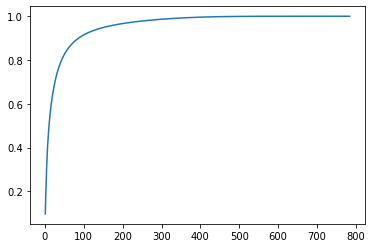

In [33]:
# 自己画的示意图，没有原图上的标注
plt.plot(range(1,785),cumsum)

图8-8：关于维度数量的解释方差函数

### PCA压缩

显然，降维之后训练集占用的空间要小得多。例如，对MNIST数据集应用主成分分析，然后保留其方差的95%。原来每个实例的784个特征变得只有150多个特征。所以这保留了绝大部分差异性的同时，数据集的大小变为不到原始的20%！这是一个合理的压缩比，可以看看它如何极大提升分类算法（例如SVM分类器）的速度。

在PCA投影上运行投影的逆转换，也可以将缩小的数据集解压缩回784维数据集。当然，得到的并非原始的数据，因为投影时损失了一部分信息（5%被丢弃的方差），但是它很大可能非常接近于原始数据。原始数据和重建数据（压缩之后解压缩）之间的均方距离，被称为`重建误差`。例如，以下代码将MNIST数据集压缩到153维，然后使用`inverse_transform()`方法将其解压缩回784维。图8-9显示了原始数据集的部分数字（左），以及这些数字经过压缩和解压缩之后的图像。可以看出图像质量有轻微损伤，但是数字基本完好无损。

In [34]:
pca = PCA(n_components = 153)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [35]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

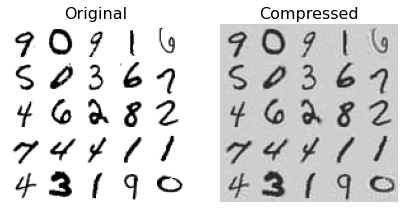

In [36]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

# save_fig("mnist_compression_plot")

In [37]:
X_reduced_pca = X_reduced

图8-9：MNIST数据集压缩——保留95%的方差

逆转换的方程如公式8-3所示。

$$
X_{recoverded} = X_{d-proj} \cdot W_d^T \tag{8-3} \label{8-3}
$$

公式8-3：PCA逆转换，回到原始维度

### 增量PCA

前面关于主成分分析的种种实现，问题在于，它需要整个训练集都进入内存，才能运行SVD算法。幸运的是，有`增量主成分分析`（IPCA）算法：可以将训练集分成一个个小批量，一次给IPCA算法喂一个。对于大型训练集来说，这个方法很有用，并且还可以在线应用PCA（也就是新实例产生时，算法开始运行）。

以下代码将MNIST数据集分成100个小批量（使用NumPy的`array_split()`函数），将它们提供给Scikit-Learn的`IncrementalPCA`（ http://goo.gl/FmdhUP ） [2] ，将数据集降到154维（跟之前一样）。注意，必须为每个小批量调用`partial_fit()`方法，而不是之前整个训练集的`fit()`方法：

In [38]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=153)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [39]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

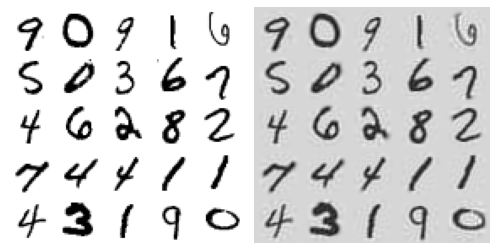

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [41]:
X_reduced_inc_pca = X_reduced

In [42]:
# 判断是否完全一致
np.allclose(pca.mean_, inc_pca.mean_)

True

In [43]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

或者，也可以使用NumPy的`memmap`类，它允许你巧妙地操控一个存储在磁盘二进制文件里的大型数组，就好似它也完全在内存里一样，而这个类（`memmap`）仅在需要时加载内存中需要的数据。由于IncrementalPCA在任何时间都只使用数组的一小部分，因此内存的使用情况仍然受控，这时可以调用常用的`fit()`方法，如以下代码所示：

In [44]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [45]:
del X_mm

In [46]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### 随机PCA

Scikit-Learn还提供了另一种实施PCA的选项，称为`随机PCA`。这是一个随机算法，可以快速找到前d个主成分的近似值。它的计算复杂度是$O(m \times d^2)+O(d^3)$，而不是$O(m \times n^2)+O(n^3)$，所以当$d$远小于$n$时，它比前面提到的算法要快得多。

In [47]:
rnd_pca = PCA(n_components=153, svd_solver="randomized", random_state=55)
X_reduced = rnd_pca.fit_transform(X_train)

[1] “On Lines and Planes of Closest Fit to Systems of Points in Space”，K.Pearson（1901）。

[2] Scikit-Learn使用的算法记录在“Incremental Learning for Robust Visual Tracking”，D.Ross等人（2007）。

## 核主成分分析

第5章讨论了核技巧，它是一种数学技巧，隐性地将实例映射到非常高维的空间（称为特征空间），从而使支持向量机能够进行非线性分类和回归。回想一下，高维特征空间的线性决策边界如何对应于原始空间中复杂的非线性决策边界。

事实证明，同样的技巧也可应用于PCA，使复杂的非线性投影降维成为可能。这就是所谓的`核主成分分析`（kPCA）（ http://goo.gl/5lQT5Q ）。 [1] 它擅长在投影后保留实例的集群，有时甚至也能展开近似于一个扭曲流形的数据集。

例如，下面的代码使用Scikit-Learn的`KernelPCA`，执行带有RBF核函数的kPCA（有关RBF核和其他核的更多细节，请参阅第5章）：

In [48]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [49]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

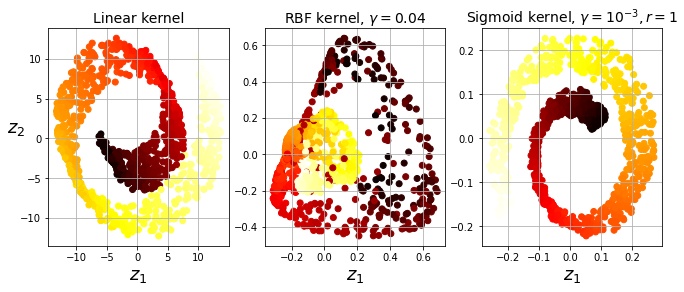

In [50]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0344, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("kernel_pca_plot")
plt.show()

图8-10显示了使用不同核函数降到二维的瑞士卷，包括线性核函数（相当于直接使用PCA类）、RBF核函数，以及sigmoid核函数（Logistic）。

### 选择核函数和调整超参数

由于kPCA是一种无监督的学习算法，因此没有明显的性能指标来帮你选择最佳的核函数和超参数值。而降维通常是监督式学习任务（例如分类）的准备步骤，所以可以使用网格搜索，来找到使任务性能最佳的核和超参数。例如，下面的代码创建了一个两步流水线，首先使用kPCA将维度降至二维，然后应用逻辑回归进行分类。接下来使用`GridSearchCV`为kPCA找到最佳的核和`gamma`值，从而在流水线最后获得最准确的分类：

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 11),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'kpca__gamma': array([0.03 , 0.032, 0.034, 0.036, 0.038, 0.04 , 0.042, 0.044, 0.046,
       0.048, 0.05 ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

最佳的核和超参数可以通过变量`best_params_`获得：

In [52]:
print(grid_search.best_params_)

{'kpca__gamma': 0.044000000000000004, 'kpca__kernel': 'rbf'}


还有一种完全不受监督方法，就是选择重建误差最低的核和超参数。但是这个重建不像线性PCA重建那样容易。来看看原因，图8-11显示了瑞士卷的原始3D数据集（左上），和应用RBF核的kPCA得到的二维数据集（右上）。因为核技巧，所以这在数学上等同于：通过特征映射函数 ，将训练集映射到无限维度的特征空间（右下），然后用线性PCA将转换后的训练集投影到2D平面。注意，如果对一个已经降维的实例进行线性PCA逆转换，重建的点将存在于特征空间，而不是原始空间中（例如，图中x表示的那个点）。而这里特征空间是无限维度的，所以无法计算出重建点，因此也无法计算出真实的重建误差。幸好，可以在原始空间中找到一个点，使其映射接近于重建点。这被称为`重建原像`。一旦有了这个原像，就可以测量它到原始实例的平方距离。最后，便可以选择使这个重建原像误差最小化的核和超参数。

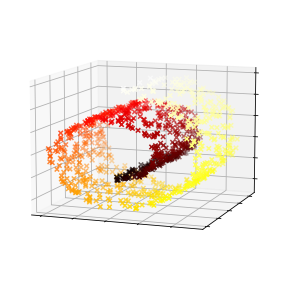

In [53]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

#save_fig("preimage_plot", tight_layout=False)
plt.show()

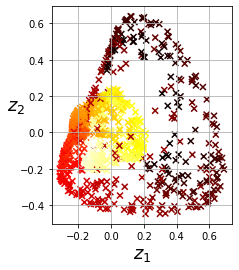

In [54]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

![图8-11：Kernel PCA和重建原像误差](images/VNote/20201125185753130_12673.png)

图8-11：Kernel PCA和重建原像误差

要怎么执行这个重建呢？方法之一是训练一个监督式回归模型，以投影后的实例作为训练集，并以原始实例作为目标。如果设置`fit_inverse_transform=True`，Scikit-Learn会自动执行该操作，如下代码所示： [2]

In [55]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.03444444,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

> 默认情况下为`fit_inverse_transform=False`，并且KernelPCA没有`inverse_transform()`方法。只有在设置`fit_inverse_transform=True`时才会创建该方法。

然后就可以计算重建原像误差：

In [56]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

7.724196566703483e-27

现在，可以使用交叉验证的网格搜索，来寻找使这个原像重建误差最小的核和超参数。

[1] “Kernel Principal Component Analysis”，B.Schölkopf、A.Smola和K.Müller（1999）。

[2] Scikit-Learn使用的算法是基于一种核岭回归算法，由Gokhan H.Bakir、Jason Weston和Bernhard Scholkopf在论文“Learning to Find Pre-images”（http://goo.gl/d0ydY6） 中提出（Tubingen，Germany：Max Planck Institute for Biological Cybernetics，2004）。

## 局部线性嵌入

`局部线性嵌入`（ https://goo.gl/iA9bns ）（LLE） [1] 是另一种非常强大的非线性降维（NLDR）技术。不像之前的算法依赖于投影，它是一种流形学习技术。简单来说，LLE首先测量每个算法如何与其最近的邻居（c.n.）线性相关，然后为训练集寻找一个能最大程度保留这些局部关系的低维表示。这使得它特别擅长展开弯曲的流形，特别是没有太多噪声时。

例如，下面的代码使用Scikit-Learn的LocallyLinearEmbedding类来展开瑞士卷。得到的二维数据集如图8-12所示。瑞士卷完全展开，实例之间的距离局部保存得很好。不过从整体来看，距离保存得不够好：展开的瑞士卷左侧被挤压，而右侧被拉长。尽管如此，对于**流形建模**来说，LLE还是做得相当不错。

In [57]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=55)

In [58]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=56)
X_reduced = lle.fit_transform(X)

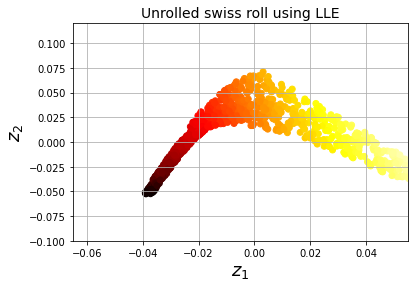

In [59]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

#save_fig("lle_unrolling_plot")
plt.show()

图8-12：使用LLE展开瑞士卷

下面是LLE的工作原理：首先，对于每个训练实例$x^{(i)}$ ，算法会识别出离它最近的$k$个邻居（上面的代码中$k=10$），然后尝试将$x^{(i)}$重建为这些邻居的线性函数。更具体来说，就是要找到权重$w_{i,j}$ 使实例$x^{(i)}$ 和$\displaystyle\sum_{j=1}^m w_{i,j}x^{(j)}$之间的距离平方最小，如果实例$x^{(j)}$不是实例$x^{(i)}$的$k$个最近的邻居之一，$w_{i,j} ＝0$。因此，LLE的第一步就是公式8-4所示的约束优化问题，其中$W$是包含所有权重$w_{i,j}$ 的权重矩阵，第二个约束则是简单地对每个训练实例$x^{(i)}$ 的权重进行归一。

$$
\hat w = \argmin_w \sum_{i=1}^m ||x^{(i)}- \sum_{j=1}^n w_{i,j}x^{(j)}||^2 \\
使得 \left \{
    \begin{array}{l}
        w_{i,j}=0 & 如果实例x^{(j)}不是实例x^{(i)}的k个最近的邻居之一 \\
        \displaystyle \sum_{j=1}^m w_{i,j} =1 & (i=1,2,\dots,m)
    \end{array}
    \right.
    \tag{8-4} \label{8-4}
$$

公式8-4：LLE第一步：对局部关系线性建模

这一步完成后，权重矩阵$\hat W$（包含权重$\hat w_{i,j}$）对训练实例之间的局部线性关系进行编码。现在，第二步就是要将训练实例映射到一个$d$维空间（$d＜n$），同时尽可能保留这些局部关系。如果$z^{(i)}$ 是实例$x^{(i)}$在这个$d$维空间的映像，那么希望从$z^{(i)}$ 到$\displaystyle \sum_{j=1}^m \hat w_{i,j}Z^{(j)}$之间的平方距离尽可能小。这个想法产生了如公式8-5描述的一个无约束优化问题。它看起来与第一步类似，但不是保持固定距离寻找最佳权重，而是保持固定权重，并在低维空间中找到每个实例映像的最佳位置。注意$Z$是包含所有$z^{(i)}$的矩阵。

$$
\hat Z = \argmin_z \sum_{i=1}^m ||z^{(i)} - \sum_{j=1}^m \hat w_{i,j} z^{(j)}||^2 \tag{8-5} \label{8-5}
$$

公式8-5：LLE第二步：保留关系并降维

Scikit-Learn的LLE实现，计算复杂度如下：寻找$k$个最近邻为$O(m \log(m)n \log(k))$；优化权重为$O(mnk^3)$；构建低维表示，为$O(dm^2)$ 。很不幸，最后一个表达式里的$m^2$说明这个算法很难扩展应用到大型数据集。

[1] “Nonlinear Dimensionality Reduction by Locally Linear Embedding”，S.Roweis和L.Saul（2000）。

## 其他降维技巧

还有许多其他的降维技术，部分可以在Scikit-Learn中找到。以下是一些最流行的：

* 多维缩放（MDS）算法，保持实例之间的距离，降低维度（见图8-13）。

* 等度量映射（Isomap）算法，将每个实例与其最近的邻居连接起来，创建连接图形，然后保留实例之间的这个测地距离， [1] 降低维度。

* t-分布随机近邻嵌入（t-SNE）算法在降低维度时，试图让相似的实例彼此靠近，不相似的实例彼此远离。它主要用于可视化，尤其是将高维空间中的实例集群可视化（例如，对MNIST图像进行二维可视化）。

* 线性判别（LDA）实际上是一种`分类算法`，但是在训练过程中，它会学习类别之间最有区别的轴，而这个轴正好可以用来定义投影数据的超平面。这样做的好处在于投影上的类别之间会尽可能的分开，所以在运行其他分类算法——比如SVM分类器之前，LDA是一个不错的降维手段。

In [60]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=55)
X_reduced_mds = mds.fit_transform(X)

In [61]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=55)
X_reduced_tsne = tsne.fit_transform(X)

In [63]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

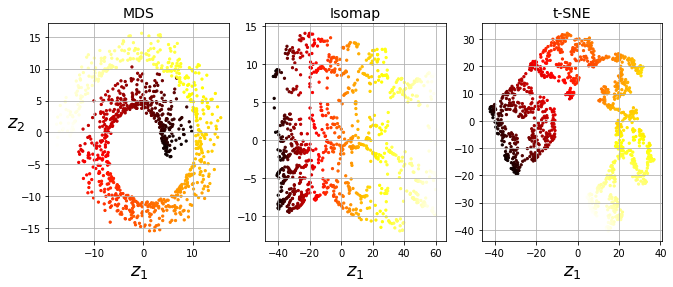

In [64]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, s=5)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("other_dim_reduction_plot")
plt.show()

图8-13：使用不同技术将瑞士卷数据集降为2D

[1] 图中两个节点之间的测地距离是两个节点之间最短路径上的节点数。

## 练习

1.降低数据集维度的主要动机是什么？有什么主要弊端？

主要动机：降低维度过多造成的计算复杂度升高；主要弊端：损失部分信息（方差）

标准答案：
* 降维的主要动机是：
- 为了加速后续的训练算法（在某些情况下，也可能为了消除噪声和冗余特征，使训练算法性能更好）
- 为了将数据可视化，并从中获得洞察，了解最重要的特征
- 只是为了节省空间（压缩）
* 主要的弊端是：
- 丢失部分信息，可能使后续训练算法的性能降低
- 可能是计算密集型的
- 为机器学习流水线增添了些许复杂度
- 转换后的特征往往难以解释

2.什么是维度的诅咒？

维度增加后，计算复杂度大幅增加。
标准答案：维度的诅咒是指许多在低维空间中不存在的问题，在高维空间中发生。在机器学习领域，一个常见的现象是随机抽样的高维向量通常非常稀疏，提升了过度拟合的风险，同时也使得在没有充足训练数据的情况下，要识别数据中的模式非常困难。

3.一旦数据集被降维，是否还有可能逆转？如果有，怎么做？如果没有，为什么？

可以被逆转。部分方法不可逆转。

标准答案：一旦使用讨论的任意算法减少了数据集的维度，几乎不可能再将操作完美地逆转，因为在降维过程中必然丢失了一部分信息。虽然有一些算法（例如PCA）拥有简单的逆转换过程，可以重建出与原始数据集相似的数据集，但是也有一些算法不能实现逆转（例如T-SNE）。

4.PCA可以用来给高度非线性数据集降维么？

可以。

标准答案：对大多数数据集来说，PCA可以用来进行显著降维，即便是高度非线性的数据集，因为它至少可以消除无用的维度。但是如果不存在无用的维度（例如瑞士卷），那么使用PCA降维将会损失太多信息。你希望的是将瑞士卷展开，而不是将其压扁。

5.假设你在一个1000维数据集上执行PCA，方差解释比设为95%。产生的结果数据集维度是多少？

取决于数据集的具体情况。

标准答案：这是个不好回答的问题，它取决于数据集。来看看两个极端的例子。首先，假设数据集是由几乎完全对齐的点组成的，在这种情况下，PCA可以将数据集降至一维，同时保留95%的差异性。现在，试想数据集由完全随机的点组成，分散在1000个维度上，在这种情况下，需要在1000个维度上保留95%的差异性。所以，这个问题的答案是：取决于数据集，它可能是1到1000之间的任何数字。将解释方差绘制成关于维度数量的函数，可以对数据集的内在维度获得一个粗略的概念。

6.常规PCA、增量PCA、随机PCA及核PCA各适用于何种情况？

标准答案：常规PCA是默认选择，但是它仅适用于内存足够处理训练集的时候。增量PCA对于内存无法支持的大型数据集非常有用，但是它比常规PCA要来得慢一些，所以如果内存能够支持，还是应该使用常规PCA。当需要随时应用PCA来处理每次新增的实例时，增量PCA对于在线任务同样有用。当想大大降低维度数量，并且内存能够支持数据集时，使用随机PCA非常有效，它比常规PCA快得多。最后对于非线性数据集，使用核化PCA行之有效。

7.如何在你的数据集上评估降维算法的性能？

标准答案：直观来说，如果降维算法能够消除许多维度并且不会丢失太多信息，那么这就算一个好的降维算法。进行衡量的方法之一是应用逆转换然后测量重建误差。然而并不是所有的降维算法都提供了逆转换。还有另一种选择，如果将降维当作一个预处理过程，用在其他机器学习算法（比如随机森林分类器）之前，那么可以通过简单测量第二个算法的性能来进行评估。如果降维过程没有损失太多信息，那么第二个算法的性能应该跟使用原始数据集一样好。

8.链接两个不同的降维算法有意义么？

有意义，可以通过不同角度进行降维。

标准答案：链接两个不同的降维算法绝对是有意义的。常见的例子是使用PCA快速去除大量无用的维度，然后应用另一种更慢的降维算法，如LLE。这样两步走的策略产生的结果可能与仅使用LLE相同，但是时间要短得多。

9.加载MNIST数据集（第3章中介绍），将其分为一个训练集和一个测试集（将前60000个实例用于训练，其余10000个用来测试）。在训练集上训练一个随机森林分类器，并记录训练时长，然后在测试集上对结果模型进行评估。接下来，用PCA给数据集降维，方差解释比设为95%。在降维后的新数据集上训练一个新的随机森林分类器，看看需要多长时间，是不是快得多？最后，在测试集上评估分类器，跟前一个分类器比起来如何？

In [65]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist['data'], mnist['target'], 
                                                    test_size=10000, random_state=55)

In [67]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs=-1)

In [68]:
%%time
clf_rf.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 726 ms, total: 2min 5s
Wall time: 9.4 s


RandomForestClassifier(n_jobs=-1)

In [69]:
from sklearn.metrics import accuracy_score

y_pred = clf_rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.9676

In [70]:
from sklearn.decomposition import PCA

pca_rf = PCA(n_components=0.95)

X_pca_reduced_rf = pca_rf.fit_transform(X_train)

In [71]:
%%time
clf_rf.fit(X_pca_reduced_rf, y_train)

CPU times: user 3min 43s, sys: 1.52 s, total: 3min 45s
Wall time: 15.9 s


RandomForestClassifier(n_jobs=-1)

In [72]:
X_test_reduced_pca_rf = pca_rf.transform(X_test)
y_pred_reduced_pca_rf = clf_rf.predict(X_test_reduced_pca_rf)
accuracy_score(y_pred_reduced_pca_rf, y_test)

0.9452

In [73]:
# Softmax分类
from sklearn.linear_model import LogisticRegression
import time

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=55)

In [74]:
%%time
log_clf.fit(X_train, y_train)

CPU times: user 4min 34s, sys: 3min 9s, total: 7min 43s
Wall time: 31.3 s


/home/zhuangbin/pyenv/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=55)

In [75]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9203

In [76]:
%%time
log_clf.fit(X_pca_reduced_rf, y_train)

CPU times: user 1min 50s, sys: 2min 13s, total: 4min 3s
Wall time: 16.1 s


/home/zhuangbin/pyenv/jupyter/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=55)

In [77]:
y_pred_reduced_pca_rf = log_clf.predict(X_test_reduced_pca_rf)
accuracy_score(y_test, y_pred_reduced_pca_rf)

0.9157

So there you have it: PCA can give you a formidable speedup... but not always!

10.使用t-SNE将MNIST数据集降至两个维度，然后用Matplotlib绘制结果。你可以通过散点图——用10个不同的颜色来代表每个图像的目标类别，或者，你也可以在每个实例的位置写入彩色数字，甚至你还可以绘制数字图像本身的缩小版（如果你绘制所有数字，视觉效果会太凌乱，所以你要么绘制一个随机样本，要么选择单个实例，但是这个实例的周围最好没有其他绘制的实例）。现在你应该得到了一个很好的可视化结果及各自分开的数字集群。尝试使用其他降维算法，如PCA、LLE或MDS等，比较可视化结果。

以上练习的解答可从附录A中获得。

In [78]:
np.random.seed(55)

In [79]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=55, n_jobs=-1)

In [80]:
%%time
X_reduced_tsne = tsne.fit_transform(X_test)

CPU times: user 27min 42s, sys: 1.23 s, total: 27min 43s
Wall time: 1min 56s


In [81]:
X_reduced_tsne.shape

(10000, 2)

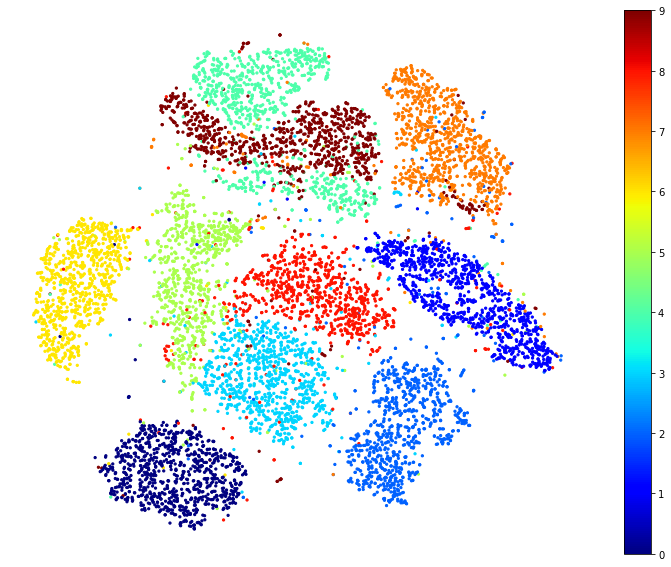

In [82]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y_test, cmap="jet", s=5)
plt.axis('off')
plt.colorbar()
plt.show()

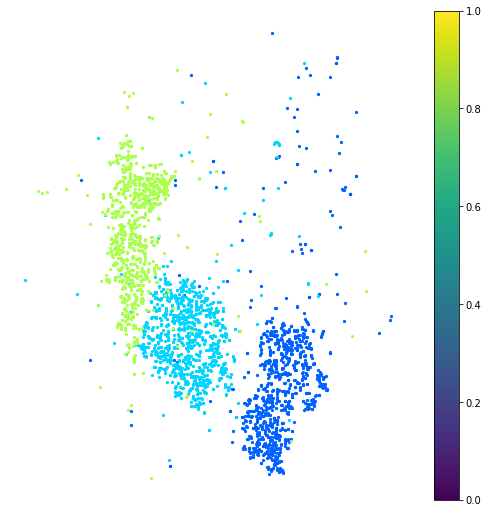

In [83]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced_tsne[y_test == digit, 0], X_reduced_tsne[y_test == digit, 1], c=[cmap(digit / 9)], s=5)
plt.axis('off')
plt.colorbar()
plt.show()

In [84]:
idx = (y_test == 2) | (y_test == 3) | (y_test == 5) 
X_subset = X_test[idx]
y_subset = y_test[idx]

tsne_subset = TSNE(n_components=2, random_state=55, n_jobs=-1)

In [85]:
%%time
X_subset_reduced = tsne_subset.fit_transform(X_subset)

CPU times: user 5min 41s, sys: 20.6 ms, total: 5min 41s
Wall time: 23.7 s


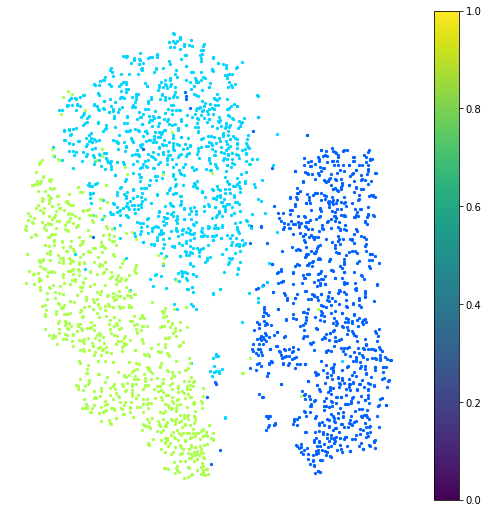

In [86]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)], s=5)
plt.axis('off')
plt.colorbar()
plt.show()

In [87]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)], s=5)
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

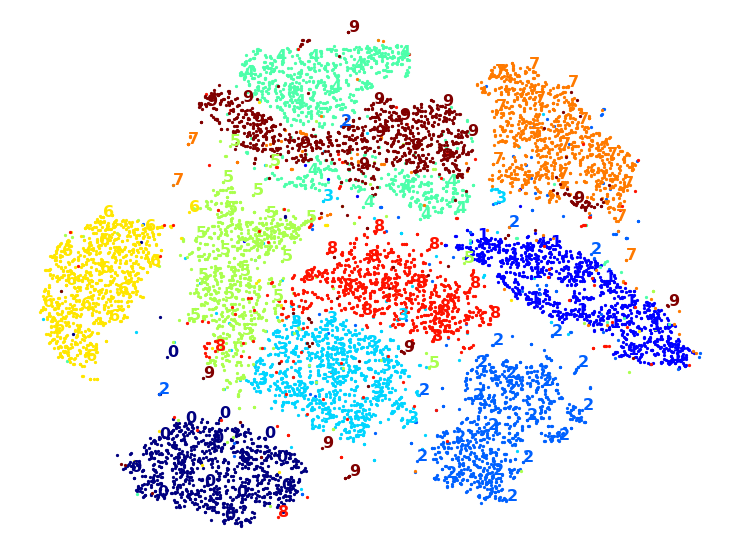

In [88]:
plot_digits(X_reduced_tsne, y_test)

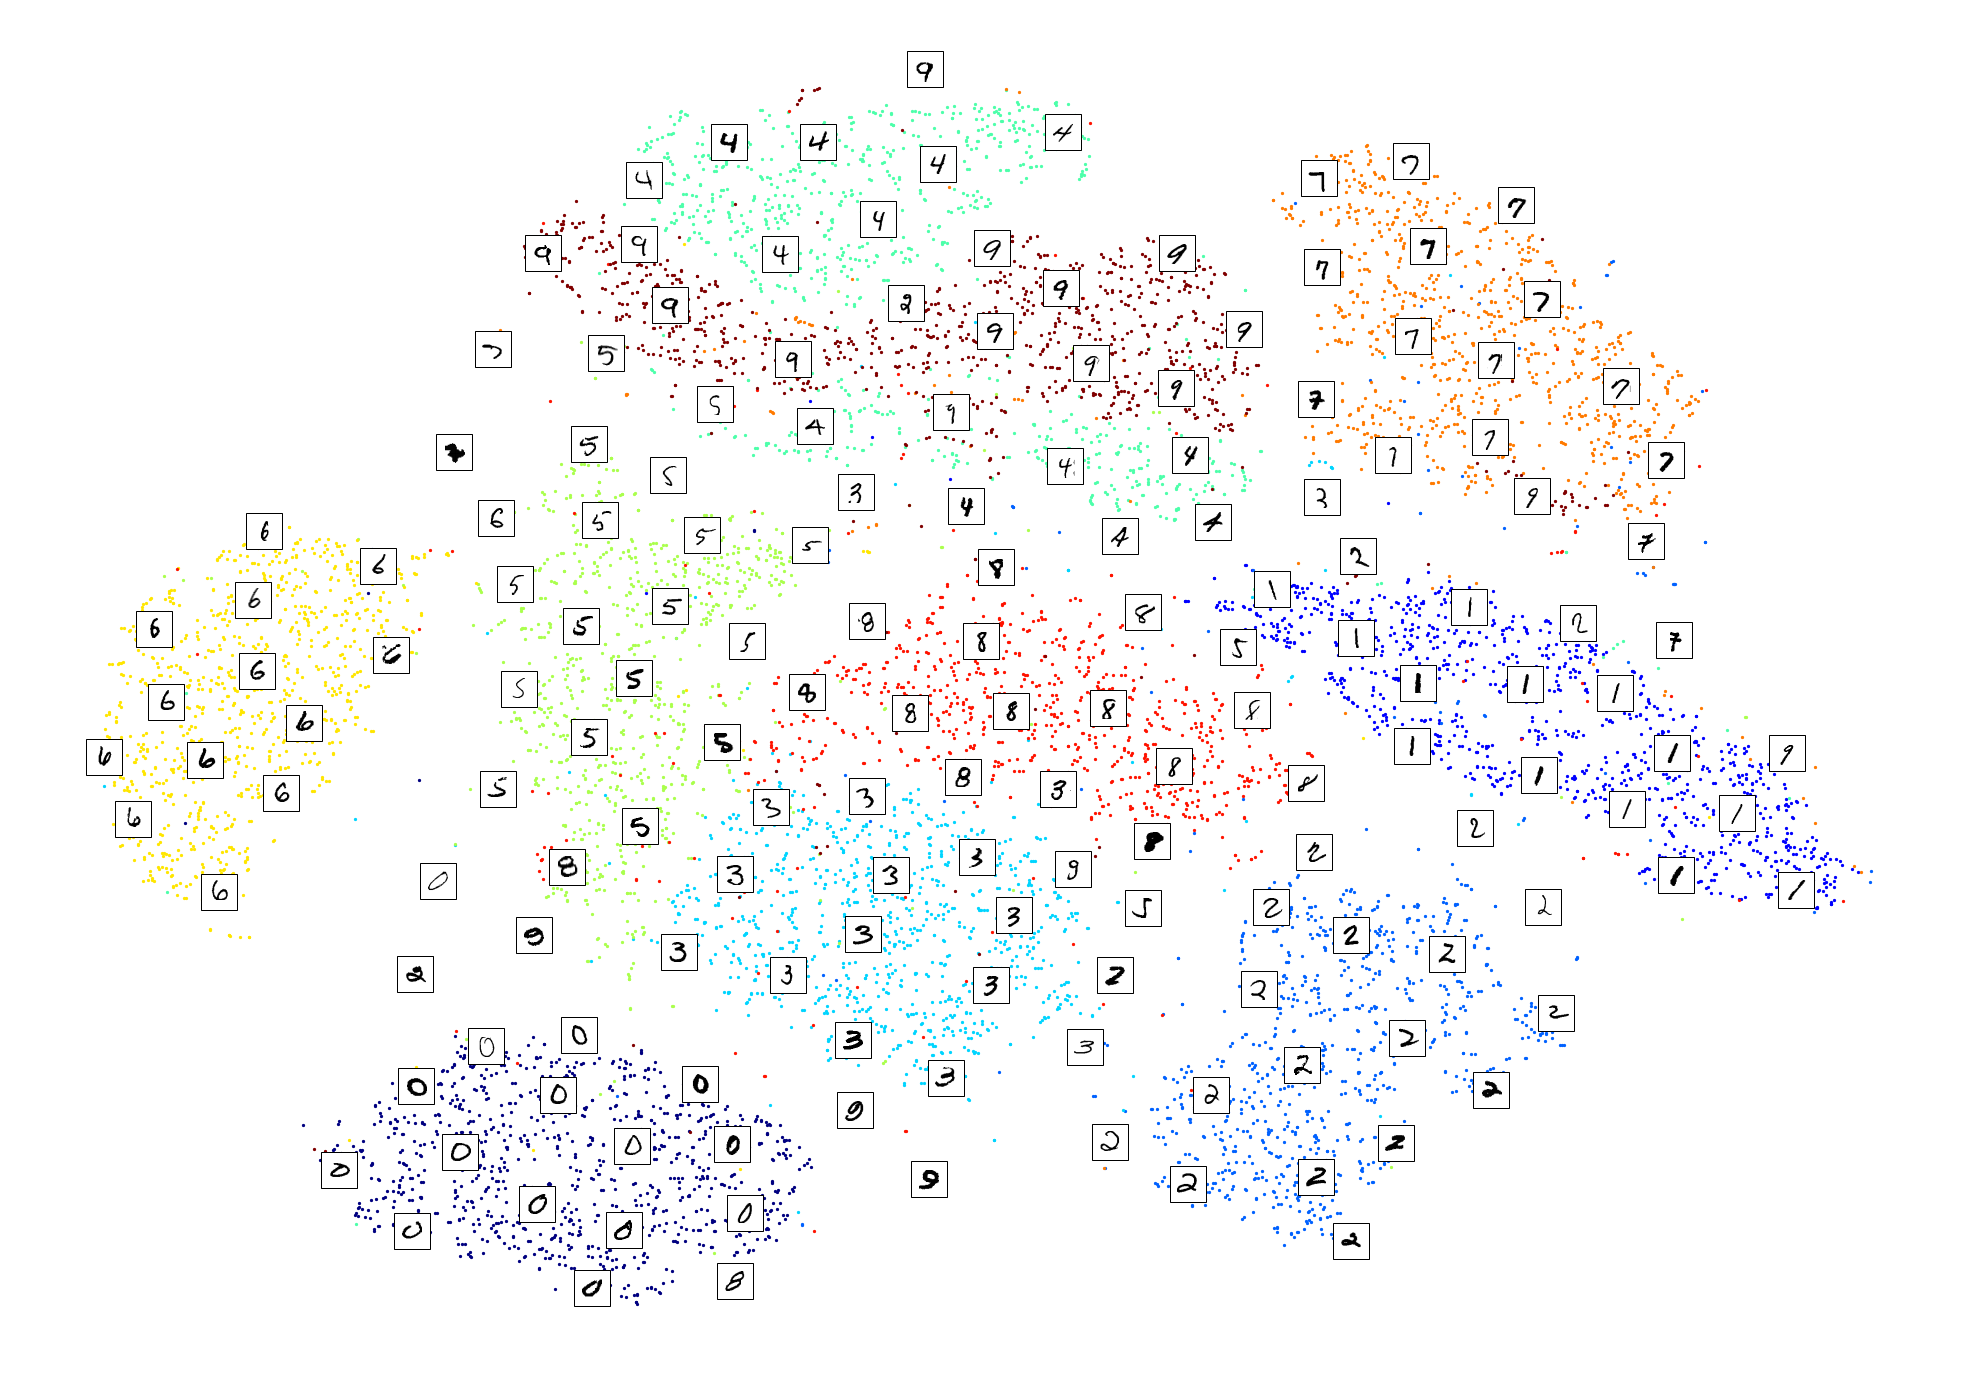

In [89]:
plot_digits(X_reduced_tsne, y_test, images=X_test, figsize=(35, 25))

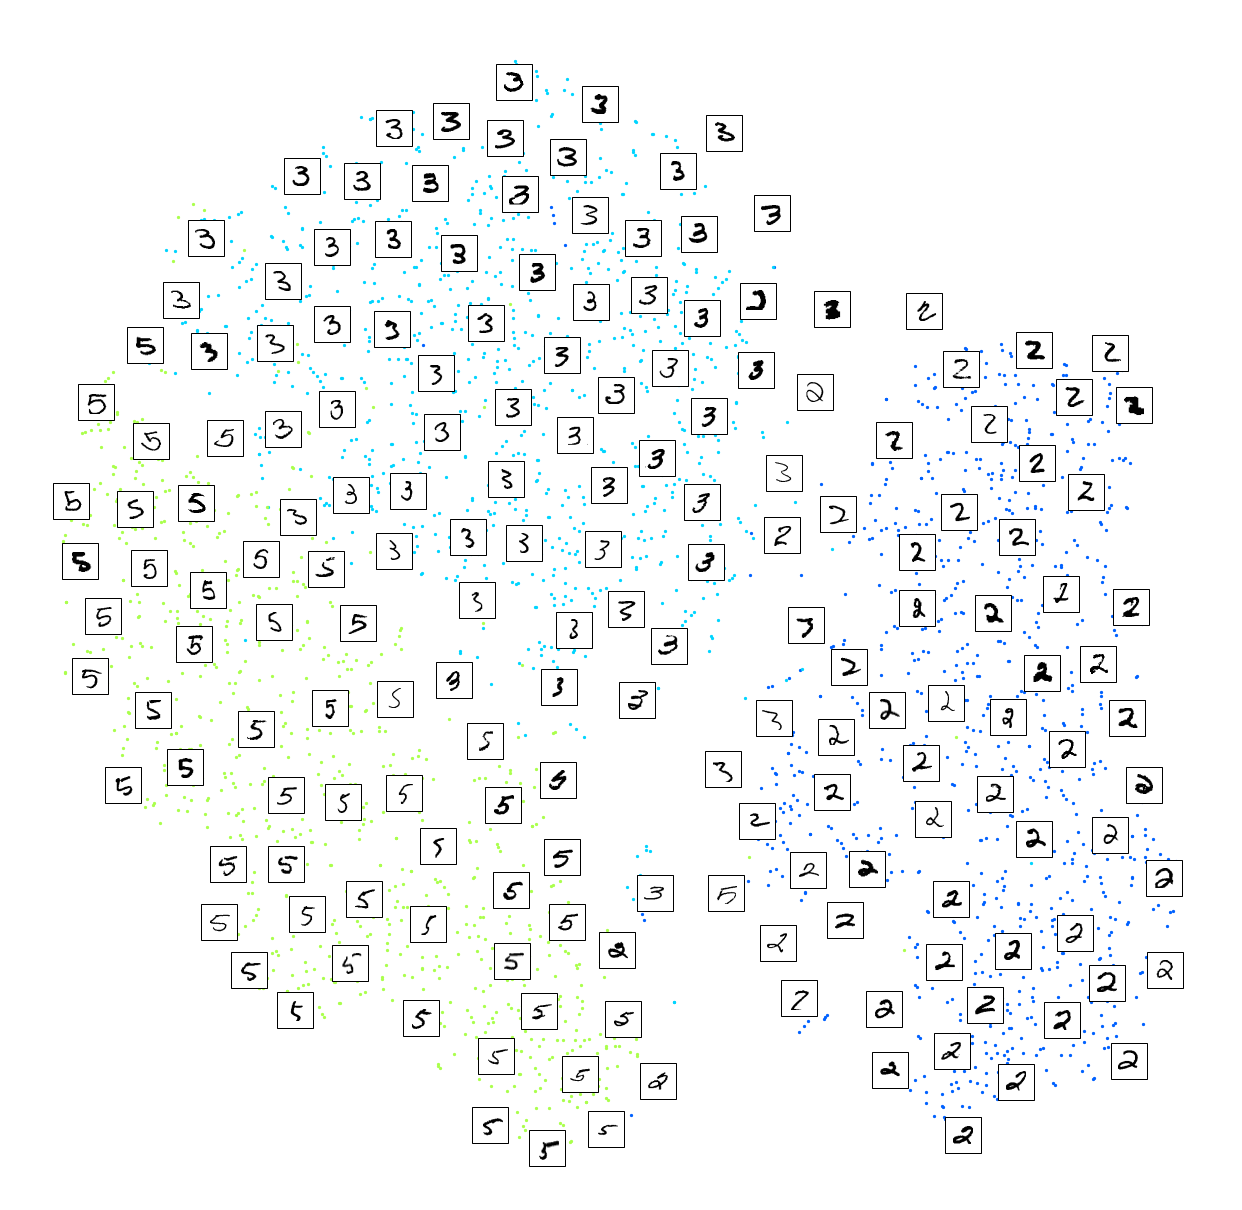

In [90]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA took 0.8s.


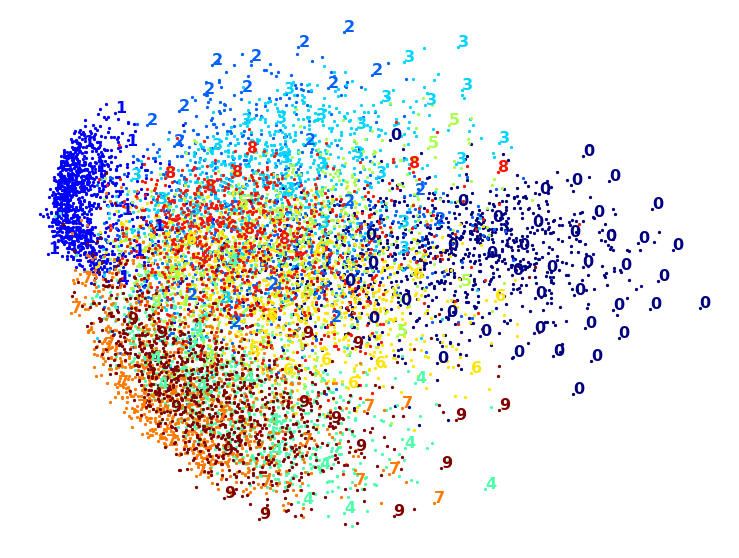

In [91]:
# With PCA
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=55).fit_transform(X_test)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y_test)
plt.show()

LLE took 126.0s.


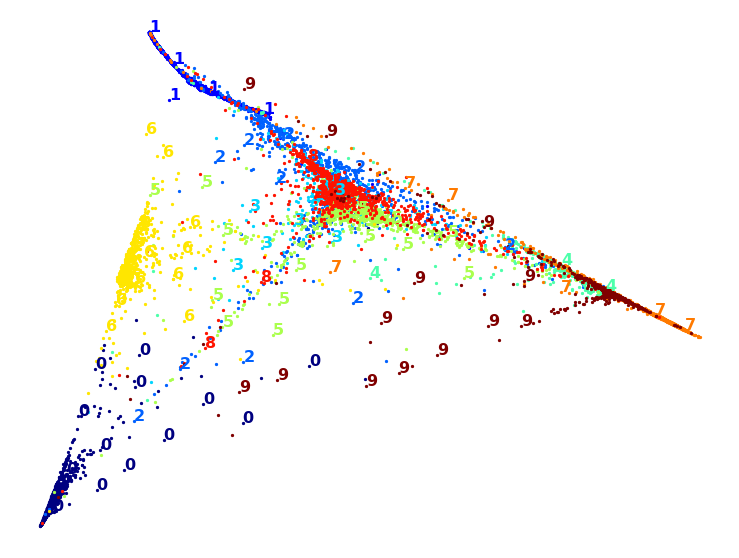

In [92]:
# With LLE
# 60K的训练集速度极慢，所以使用10K的测试集
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=55, n_jobs=-1).fit_transform(X_test)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y_test)
plt.show()

PCA+LLE took 64.7s.


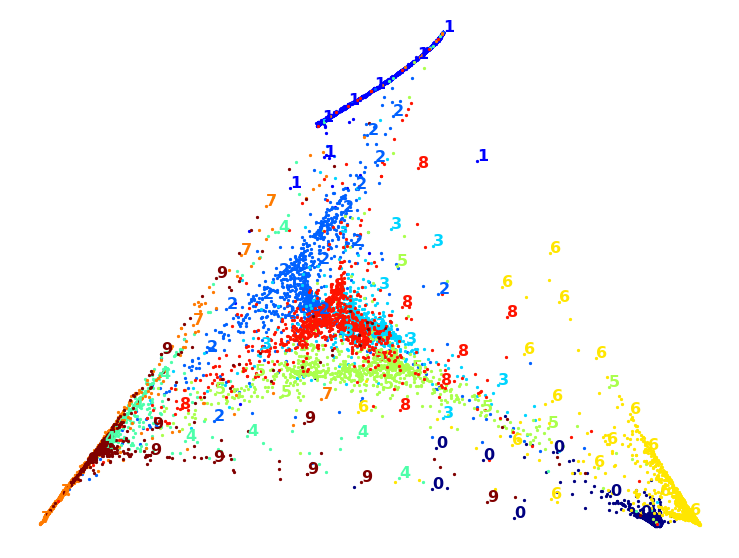

In [93]:
# PCA + LLE
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=55)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=55, n_jobs=-1)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X_test)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y_test)
plt.show()

In [94]:
# With MDS
m = 2000
idx = np.random.permutation(10000)[:m]

In [95]:
X_test[idx].shape

(2000, 784)

MDS took 96.2s (on just 2,000 MNIST images instead of 10,000).


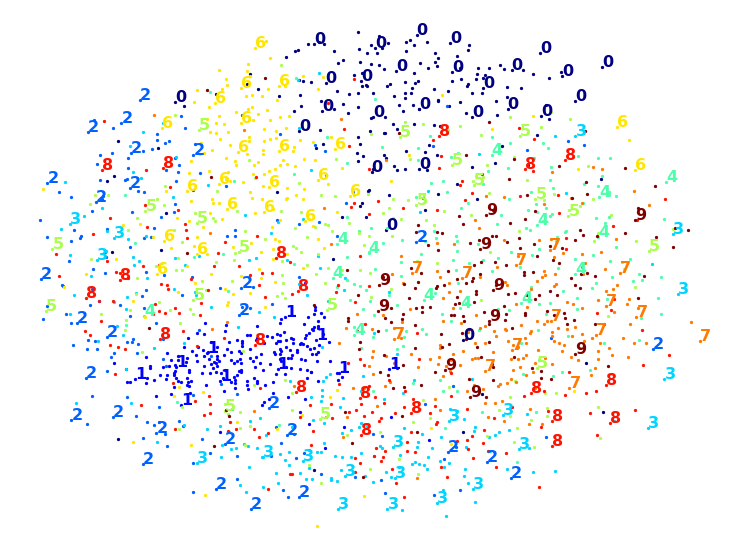

In [96]:
from sklearn.manifold import MDS

t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=55, n_jobs=-1).fit_transform(X_test[idx])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y_test[idx])
plt.show()

PCA+MDS took 98.8s (on 2,000 MNIST images).


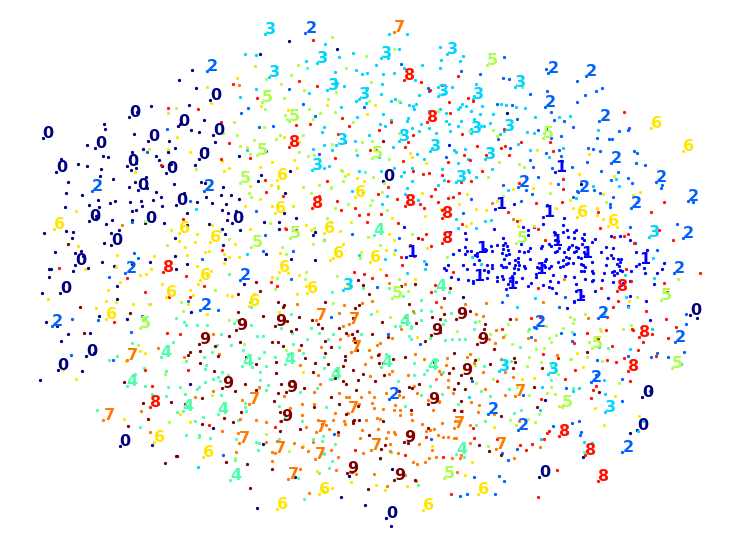

In [97]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=55)),
    ("mds", MDS(n_components=2, random_state=55, n_jobs=-1)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X_test[idx])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y_test[idx])
plt.show()

LDA took 4.8s.


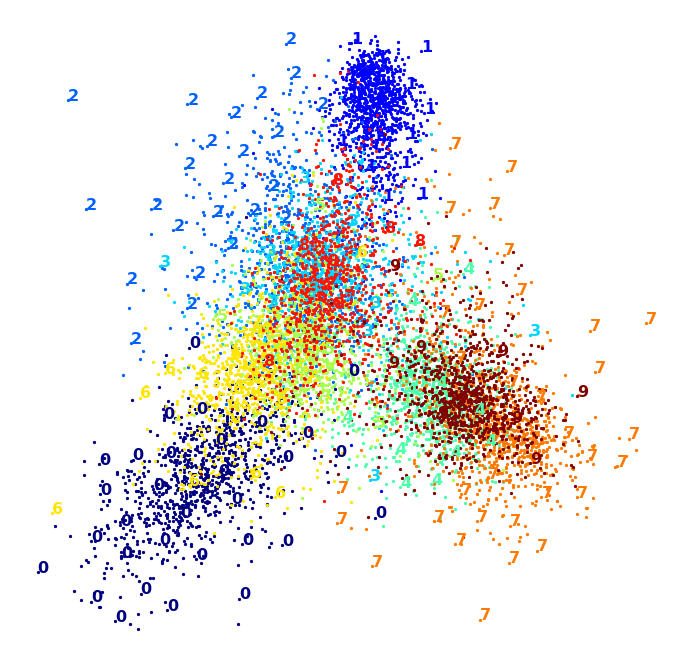

In [98]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X_test, y_test)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y_test, figsize=(12,12))
plt.show()

t-SNE took 107.0s.


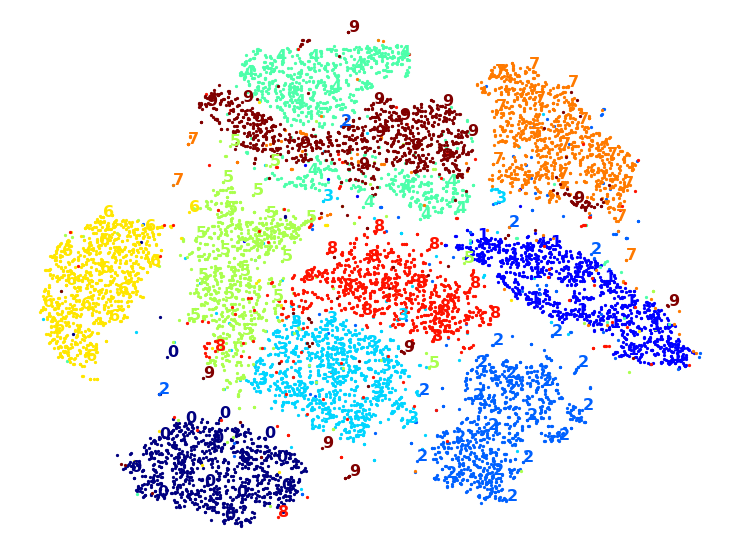

In [99]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=55, n_jobs=-1).fit_transform(X_test)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y_test)
plt.show()

PCA+t-SNE took 65.1s.


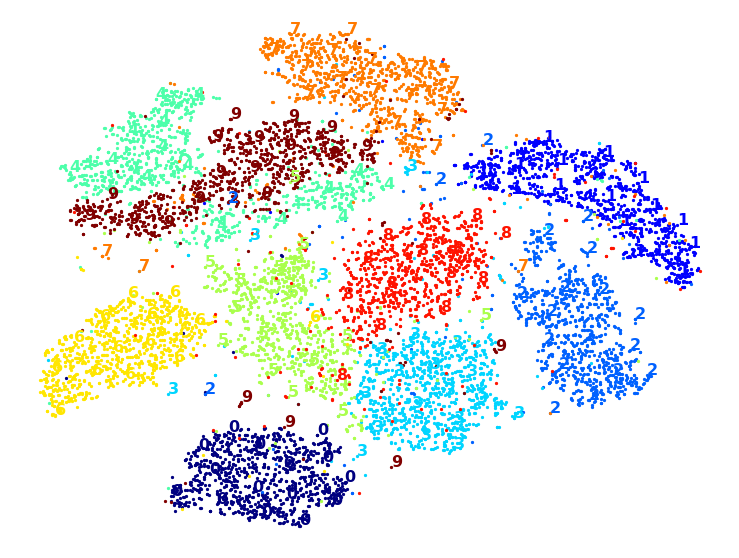

In [100]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=55)),
    ("tsne", TSNE(n_components=2, random_state=55, n_jobs=-1)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_test)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y_test)
plt.show()

最终的结论是非线性降维使用t-SNE效果最好。